## 모델 학습하기
철헌님 코드 활용하였습니다.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split



from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding, Dense, Dropout, Conv1D, GlobalMaxPooling1D, BatchNormalization

from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

from gensim.models import Word2Vec
from konlpy.tag import Okt

import pickle
from tensorflow.keras.optimizers import Adam

In [34]:
# mount to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# import text data from ../raw-data/ directory
os.getcwd()
data_dir = os.getcwd() + '/drive/MyDrive/aiffel/dlthon/raw-data'
print(data_dir)

/content/drive/MyDrive/aiffel/dlthon/raw-data


In [36]:
train_data = pd.read_csv(data_dir + '/train_with_gen_conv.csv')

#### 이미 전처리해서 중복 등을 제거한 좋은 데이터로 시작
각 클래스는 정수인코딩 되어있고   
협박 대화 = 0,  
갈취 대화 = 1,  
직장 내 괴롭힘 대화 = 2,  
기타 괴롭힘 대화 = 3,  
일반 = 4   

In [46]:
label_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

train_data['class'] = train_data['class'].apply(lambda x: label_mapping[x])
train_data

,idx,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
4080,4080,4,능력 있는 사람이 되고 싶어... 너도 충분히 능력 있어. ...정말 그렇게 생각해...
4081,4081,4,능력을 키우려면 뭘 해야 할까? 꾸준히 노력하고 배우는 게 중요하지 않을까? 맞아....
4082,4082,4,너는 능력이 뛰어나서 부럽다... 고맙다~ 하지만 나도 부족한 점이 많아. 그래도 ...
4083,4083,4,능력이란 게 뭘까? 자신의 일을 잘 해내는 거 아닐까? 맞아. 나도 그런 사람이 되...


#### 한국어 형태소 분석 후 word2vec

In [47]:
okt=Okt()

tokenized_data = [okt.morphs(sentence) for sentence in train_data['conversation']]

embedding_model = Word2Vec(sentences=tokenized_data,
							sg = 1,
                            vector_size = 128,
                            window = 10,
                            min_count = 1,
                            workers = 4)

In [48]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tokenized_data)
train_X = tokenizer.texts_to_sequences(tokenized_data)

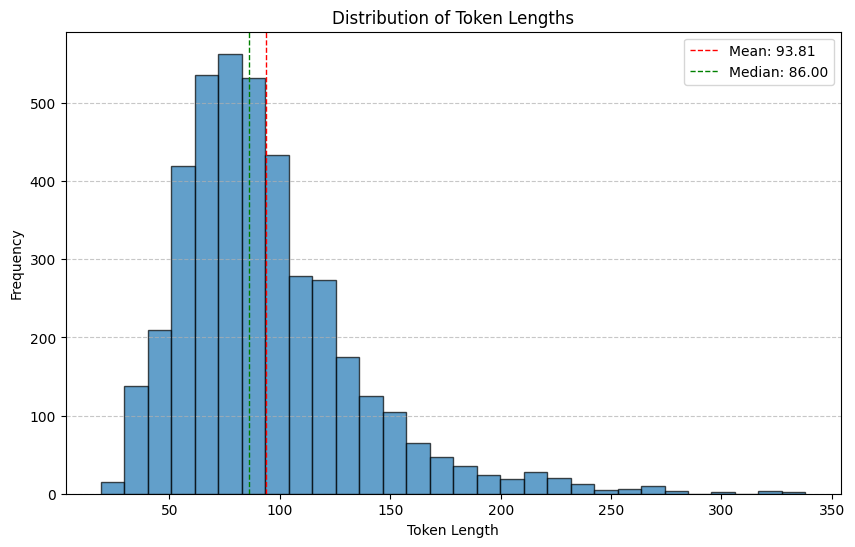

169.79999999999973


In [49]:
# Compute token lengths
token_lengths = [len(seq) for seq in train_X]

# Compute statistics
mean_length = np.mean(token_lengths)
std_length = np.std(token_lengths)
min_length = np.min(token_lengths)
max_length = np.max(token_lengths)
median_length = np.median(token_lengths)

# Create a DataFrame for statistics
stats_df = pd.DataFrame({
    "Statistic": ["Mean", "Standard Deviation", "Min", "Max", "Median"],
    "Value": [mean_length, std_length, min_length, max_length, median_length]
})

# Plot histogram of token lengths
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_length:.2f}')
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of Token Lengths")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(np.percentile(token_lengths, 95))


In [50]:
vocab_size=10000
embedding_dim=256
max_len = 150 # 평균 + 1.5 * 표준편차 한 것

train_X = tokenizer.texts_to_sequences(tokenized_data)
train_X = pad_sequences(train_X, maxlen=max_len, padding='pre')
train_y = train_data['class'].values

In [51]:
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

In [52]:
print(f"training data size: {len(train_X)}")
print(f"validation data size: {len(val_X)}")

training data size: 3268
validation data size: 817


### 스태킹 앙상블 기법을 활용하기 위해 kernel_size와 dropout rate이 다른 세 모델 형성

In [136]:
def textcnn_model(kernel_size, dropout):
    model = Sequential()

    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(Conv1D(192, kernel_size=kernel_size, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.add(Dense(192, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [137]:
# 모델 3개 생성
TextCNN1 = textcnn_model(kernel_size=3, dropout=0.3)
TextCNN2 = textcnn_model(kernel_size=4, dropout=0.4)
TextCNN3 = textcnn_model(kernel_size=5, dropout=0.5)

# callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


# epochs
NUM_EPOCHS = 10


# 모델 학습
history1 = TextCNN1.fit(train_X, train_y,
                        batch_size = 32,
                        epochs = NUM_EPOCHS,
                        validation_data = (val_X, val_y),
                        callbacks=[es, lr]
                       )

history2 = TextCNN2.fit(train_X, train_y,
                        batch_size = 32,
                        epochs = NUM_EPOCHS,
                        validation_data = (val_X, val_y),
                        callbacks=[es, lr]
                       )

history3 = TextCNN3.fit(train_X, train_y,
                        batch_size = 32,
                        epochs = NUM_EPOCHS,
                        validation_data = (val_X, val_y),
                        callbacks=[es, lr]
                       )


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.3801 - loss: 3.4940 - val_accuracy: 0.2521 - val_loss: 3.2894 - learning_rate: 0.0010
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8452 - loss: 2.0741 - val_accuracy: 0.2521 - val_loss: 2.9035 - learning_rate: 0.0010
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9599 - loss: 1.4741 - val_accuracy: 0.2521 - val_loss: 2.4912 - learning_rate: 0.0010
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9796 - loss: 1.1468 - val_accuracy: 0.4529 - val_loss: 1.9534 - learning_rate: 0.0010
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9902 - loss: 0.9061 - val_accuracy: 0.7895 - val_loss: 1.4346 - learning_rate: 0.0010
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9856 - loss: 0.7382 - val_accuracy: 0.8152 - val_loss: 1.1123 - learning_rate: 0.0010
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9743 - loss: 0.6523 - val_accura

In [138]:
pred_train1 = TextCNN1.predict(train_X)
pred_train2 = TextCNN2.predict(train_X)
pred_train3 = TextCNN3.predict(train_X)
meta_train = np.concatenate([pred_train1, pred_train2, pred_train3], axis=1)

pred_val1 = TextCNN1.predict(val_X)
pred_val2 = TextCNN2.predict(val_X)
pred_val3 = TextCNN3.predict(val_X)
meta_val = np.concatenate([pred_val1, pred_val2, pred_val3], axis=1)

103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [139]:
print(meta_train[:1])
print(meta_train.shape[1])
print(train_y[:1])

[[2.7885388e-03 9.7830325e-01 1.8473121e-03 1.5843738e-02 1.2170826e-03
  6.5911392e-04 9.9502510e-01 1.8554208e-03 2.2753519e-03 1.8508124e-04
  1.1875049e-02 9.6720034e-01 2.6065107e-03 1.5834719e-02 2.4834380e-03]]
15
[1]


In [140]:
# 메타 모델
meta_model = Sequential()

meta_model.add(Dense(128, activation='gelu', input_shape=(15,), kernel_regularizer=regularizers.l2(0.01)))
meta_model.add(BatchNormalization())
meta_model.add(Dropout(0.4))
meta_model.add(Dense(64, activation='gelu', kernel_regularizer=regularizers.l2(0.01)))
meta_model.add(BatchNormalization())
meta_model.add(Dropout(0.4))
meta_model.add(Dense(32, activation='gelu', kernel_regularizer=regularizers.l2(0.01)))
meta_model.add(BatchNormalization())
meta_model.add(Dropout(0.4))
meta_model.add(Dense(5, activation='softmax'))

meta_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])

# Stacking 학습
meta_model.fit(meta_train, train_y,
               validation_data=(meta_val, val_y),
               epochs=15,
               batch_size=64,
               callbacks=[es, lr]
              )


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.7957 - loss: 2.0142 - val_accuracy: 0.6267 - val_loss: 1.9353 - learning_rate: 0.0050
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9968 - loss: 0.6159 - val_accuracy: 0.4480 - val_loss: 1.6399 - learning_rate: 0.0050
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9955 - loss: 0.2737 - val_accuracy: 0.6267 - val_loss: 1.4575 - learning_rate: 0.0050
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9952 - loss: 0.2130 - val_accuracy: 0.7405 - val_loss: 1.2633 - learning_rate: 0.0050
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9971 - loss: 0.1667 - val_accuracy: 0.7711 - val_loss: 1.1592 - learning_rate: 0.0050
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9997 - loss: 0.1076 - val_accuracy: 0.7931 - val_loss: 1.2108 - learning_rate: 0.0050
Epoch 7/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0627 - val_accuracy: 0.7944 -

In [141]:
# 검증 데이터 예측
val_preds = meta_model.predict(meta_val)
val_preds_classes = np.argmax(val_preds, axis=1)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [142]:
from sklearn.metrics import f1_score

f1 = f1_score(val_y, val_preds_classes, average="weighted")  # weighted F1-score
print(f"Weighted F1-score: {f1:.4f}")

Weighted F1-score: 0.8524


In [143]:
report = classification_report(val_y, val_preds_classes, target_names=[f"Class {i}" for i in range(5)])
print(report)

              precision    recall  f1-score   support

     Class 0       0.91      0.72      0.80       187
     Class 1       0.86      0.86      0.86       214
     Class 2       0.95      0.93      0.94       190
     Class 3       0.73      0.90      0.81       206
     Class 4       1.00      0.80      0.89        20

    accuracy                           0.85       817
   macro avg       0.89      0.84      0.86       817
weighted avg       0.86      0.85      0.85       817



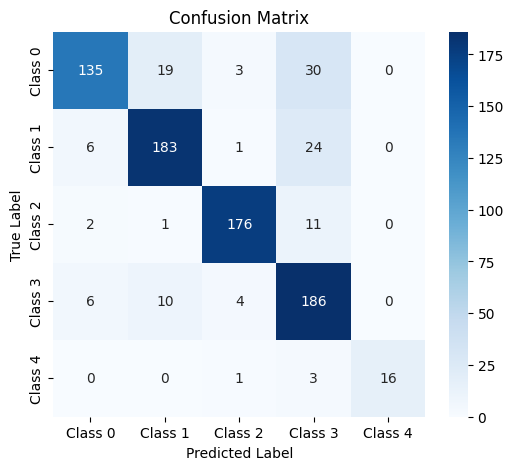

In [144]:
# Confusion Matrix 계산
cm = confusion_matrix(val_y, val_preds_classes)

# Confusion Matrix 시각화
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f"Class {i}" for i in range(5)], yticklabels=[f"Class {i}" for i in range(5)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [145]:
# val_y의 각 클래스 개수 출력
unique_classes, class_counts = np.unique(val_y, return_counts=True)

# 결과 출력
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count}개")


Class 0: 187개
Class 1: 214개
Class 2: 190개
Class 3: 206개
Class 4: 20개


In [146]:
test_df = pd.read_csv(data_dir + '/test.csv')

In [147]:
test_texts = test_df['text'].tolist()  # 테스트 데이터의 텍스트 추출
tokenized_test = [okt.morphs(sentence) for sentence in test_texts]  # 형태소 분석 적용
test_X = tokenizer.texts_to_sequences(tokenized_test)  # 기존에 학습된 Tokenizer를 사용해 정수 인덱스로 변환
test_X = pad_sequences(test_X, maxlen=max_len, padding='pre')

print("Test 데이터 Shape:", len(test_X))  # (샘플 수, max_len)

Test 데이터 Shape: 500


In [148]:
pred_test1 = TextCNN1.predict(test_X)
pred_test2 = TextCNN2.predict(test_X)
pred_test3 = TextCNN3.predict(test_X)

meta_test = np.concatenate([pred_test1, pred_test2, pred_test3], axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [149]:
test_pred = meta_model.predict(meta_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [150]:
print(len(test_pred))

500


In [151]:
test_pred[0]

array([0.28058872, 0.04964601, 0.16819598, 0.46459147, 0.03697776],
      dtype=float32)

In [152]:
test_pred_labels = np.argmax(test_pred,axis=1)

In [153]:
test_pred_labels[:20]

array([3, 2, 2, 3, 3, 0, 0, 1, 3, 1, 0, 3, 2, 2, 2, 1, 3, 3, 0, 3])

In [154]:
# 인덱스 열 생성 (t_000 ~ t_499)
idx_column = [f"t_{i:03d}" for i in range(len(test_pred_labels))]

# DataFrame 생성
submission_df = pd.DataFrame({
    "idx": idx_column,
    "target": test_pred_labels
})

# 확인
print(submission_df.head(10))  # 상위 10개 출력

# CSV로 저장
submission_df.to_csv(data_dir + "submission_textcnn.csv", index=False)

print("CSV 저장 완료: submission_textcnn.csv")


     idx  target
0  t_000       3
1  t_001       2
2  t_002       2
3  t_003       3
4  t_004       3
5  t_005       0
6  t_006       0
7  t_007       1
8  t_008       3
9  t_009       1
CSV 저장 완료: submission_textcnn.csv


In [155]:
# 클래스 개수 확인
class_distribution = pd.Series(submission_df['target']).value_counts().sort_index()
print(class_distribution)


target
0     99
1    122
2    127
3    152
Name: count, dtype: int64
